# XAI605 Midterm – MDN Training & Evaluation (Annotated)

## 1) Load & Inspect Noisy Training Data

In [1]:
# SECTION 1 — Load noisy training data from data2/noisy_data.npz and print the available keys and shapes.
# No logic changes: this only documents data inspection.

import numpy as np
import matplotlib.pyplot as plt
from jit_wrap import save_jit_model
from local_mdn import get_argmax_mu
import os

data_train = np.load('data2/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2) Visualize Noisy Training Data

### Imports & load the practice set

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset 1 (practice / noisy train). Make sure the path matches your repo layout.
data_train = np.load("data1/noisy_data.npz")  # returns a dict-like NpzFile
print("Keys:", data_train.files)              # sanity: expect ['x','y']


Keys: ['x', 'y']


### Extract, cast, and flatten (critical)

In [3]:
# Extract
x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Cast to numeric (guards against object dtype) and flatten to 1-D
x_train_in = np.asarray(x_train_in, dtype=np.float32).reshape(-1)
y_train_in = np.asarray(y_train_in, dtype=np.float32).reshape(-1)

# Final shape sanity check
assert x_train_in.ndim == 1 and y_train_in.ndim == 1, "x/y must be 1-D"
assert x_train_in.size == y_train_in.size, "x and y must have the same length"
print("Shapes:", x_train_in.shape, y_train_in.shape, "dtype:", x_train_in.dtype, y_train_in.dtype)


Shapes: (800,) (800,) dtype: float32 float32


### Basic scatter

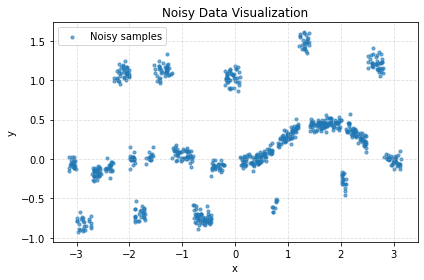

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Add structure hint (sorted line or bin-mean)

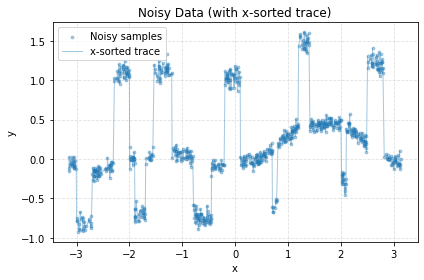

In [5]:
idx = np.argsort(x_train_in)
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=8, alpha=0.35, label="Noisy samples")
plt.plot(x_train_in[idx], y_train_in[idx], lw=1, alpha=0.4, label="x-sorted trace")
plt.title("Noisy Data (with x-sorted trace)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()


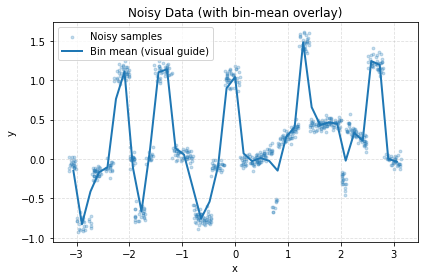

In [6]:
bins = np.linspace(x_train_in.min(), x_train_in.max(), 40)
which = np.digitize(x_train_in, bins)
xc = 0.5*(bins[:-1] + bins[1:])
mu = np.array([y_train_in[which == i].mean() if np.any(which == i) else np.nan
               for i in range(1, len(bins))])

plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=8, alpha=0.25, label="Noisy samples")
plt.plot(xc, mu, lw=2, label="Bin mean (visual guide)")
plt.title("Noisy Data (with bin-mean overlay)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()


## 3) Build a simple Mixture Density Network (PyTorch)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from util import get_torch_size_string, print_model_parameters, th2np
from local_mdn import MixtureDensityNetwork, gmm_forward, eval_mdn_1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume x_train_in, y_train_in already exist as NumPy arrays from your earlier cell.
# Ensure dtype/shape are consistent: (N, 1), float32
x_train_np = np.asarray(x_train_in, dtype=np.float32).reshape(-1, 1)
y_train_np = np.asarray(y_train_in, dtype=np.float32).reshape(-1, 1)

# (Optional) practice clean set for plotting/eval
try:
    import os
    d1_clean = np.load("data1/clean_data.npz")
    x_test_np = d1_clean["x"].astype("float32").reshape(-1, 1)
    y_test_np = d1_clean["y"].astype("float32").reshape(-1, 1)
    HAS_CLEAN = True
except Exception:
    HAS_CLEAN = False

# Torch tensors on the right device
x_train = torch.from_numpy(x_train_np).to(device)
y_train = torch.from_numpy(y_train_np).to(device)
if HAS_CLEAN:
    x_test = torch.from_numpy(x_test_np).to(device)
    y_test = torch.from_numpy(y_test_np).to(device)

n_train = x_train.shape[0]
print("n_train:", n_train, "| x_train shape:", tuple(x_train.shape), "| y_train shape:", tuple(y_train.shape))


n_train: 800 | x_train shape: (800, 1) | y_train shape: (800, 1)


In [8]:
# Model
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64, 64],
    actv=nn.SiLU(),
    # Keep sigma bounded; avoid over-constraining mu unless you normalized targets to tiny ranges
    sig_max=10.0,
    mu_min=-0.02,      # <= widen (in normalized units)
    mu_max=+0.02,
    p_drop=0.0, use_bn=False,
).to(device)

mdn.init_param()
print_model_parameters(mdn)

# Optimizer & scheduler
optm = torch.optim.Adam(mdn.parameters(), lr=3e-3, eps=1e-8, weight_decay=1e-4)  # sensible LR for MDN/Adam
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.98)  # decay ~2% per "epoch" (we'll define an epoch below)


[ 0] parameter:[       net.linear_00.weight] shape:[        64x1] numel:[        64]
[ 1] parameter:[         net.linear_00.bias] shape:[          64] numel:[        64]
[ 2] parameter:[       net.linear_03.weight] shape:[       64x64] numel:[      4096]
[ 3] parameter:[         net.linear_03.bias] shape:[          64] numel:[        64]
[ 4] parameter:[net.mixturesofgaussianlayer_06.fc_pi.weight] shape:[        5x64] numel:[       320]
[ 5] parameter:[net.mixturesofgaussianlayer_06.fc_pi.bias] shape:[           5] numel:[         5]
[ 6] parameter:[net.mixturesofgaussianlayer_06.fc_mu.weight] shape:[        5x64] numel:[       320]
[ 7] parameter:[net.mixturesofgaussianlayer_06.fc_mu.bias] shape:[           5] numel:[         5]
[ 8] parameter:[net.mixturesofgaussianlayer_06.fc_sigma.weight] shape:[        5x64] numel:[       320]
[ 9] parameter:[net.mixturesofgaussianlayer_06.fc_sigma.bias] shape:[           5] numel:[         5]


## 4)Train on Dataset 1 (practice) and evaluate on the clean set

In [9]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

max_epochs   = 30
batch_size   = 64
print_every  = 200          # iterations
plot_every   = 1000         # iterations (only if HAS_CLEAN)

iters_per_ep = (n_train + batch_size - 1) // batch_size
global_iter  = 0

mdn.train()
for epoch in range(1, max_epochs + 1):
    # Shuffle indices ON DEVICE (avoid NumPy indexing on tensors)
    perm = torch.randperm(n_train, device=device)  # returns [0..n_train-1] shuffled. :contentReference[oaicite:5]{index=5}
    for i in range(iters_per_ep):
        idx = perm[i*batch_size : (i+1)*batch_size]
        x_batch = x_train.index_select(0, idx)
        y_batch = y_train.index_select(0, idx)

        # Forward
        pi, mu, sigma = mdn(x_batch)                      # your MixtureDensityNetwork.forward
        out = gmm_forward(pi, mu, sigma, y_batch)         # expect dict with 'nlls' and 'argmax_mu'

        # Some local_mdn implementations return argmax_mu as (N,) — make it (N,1) if needed
        y_pred = out['argmax_mu']
        if y_pred.dim() == 1:
            y_pred = y_pred.unsqueeze(1)

        # Loss = mixture NLL + small L2 on dominant mean for stability
        loss = out['nlls'].mean() + 0.1 * F.mse_loss(y_pred, y_batch)  # MSE docs. :contentReference[oaicite:6]{index=6}

        # Backprop
        optm.zero_grad(set_to_none=True)                 # recommended variant. :contentReference[oaicite:7]{index=7}
        loss.backward()
        optm.step()

        # Logging
        if (global_iter % print_every) == 0:
            if HAS_CLEAN:
                mdn.eval()
                with torch.no_grad():
                    pi_t, mu_t, sg_t = mdn(x_test)
                    out_t = gmm_forward(pi_t, mu_t, sg_t, y_test)
                    yhat_t = out_t['argmax_mu']
                    if yhat_t.dim() == 1:
                        yhat_t = yhat_t.unsqueeze(1)
                    mse_clean = F.mse_loss(yhat_t, y_test).item()
                mdn.train()
                print(f"[ep {epoch:02d} | it {global_iter:05d}] loss={loss.item():.4f} | MSE(clean)={mse_clean:.4f}")
            else:
                print(f"[ep {epoch:02d} | it {global_iter:05d}] loss={loss.item():.4f}")

        # Optional: quick visual check on practice clean set
        if HAS_CLEAN and ((global_iter % plot_every) == 0) and (global_iter > 0):
            mdn.eval()
            with torch.no_grad():
                eval_mdn_1d(mdn, x_test, y_test, figsize=(12, 3), device=device)
            mdn.train()

        global_iter += 1

    # Step LR once per epoch
    schd.step()  # ExponentialLR per epoch. :contentReference[oaicite:8]{index=8}

print("Done.")


[ep 01 | it 00000] loss=3.3234 | MSE(clean)=0.2122
[ep 16 | it 00200] loss=0.7250 | MSE(clean)=0.0575
Done.


## 5) Verify your submission works with the repo’s eval.py

### Save TorchScript (JIT) Model

In [10]:
# SECTION 10 — Switch model to eval mode on CPU and export a TorchScript (.pth) using save_jit_model().

# exit()

print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists (relative to notebook)
os.makedirs('model', exist_ok=True)

# Set model to evaluation mode and move to CPU before saving
mdn.eval()
mdn.cpu()

JIT_MODEL_PATH = "model/2025021848.pth"
save_jit_model(mdn, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT tracing...
JIT-traced model saved successfully to model/2025021848.pth


### Evaluate Saved Model with eval.py 

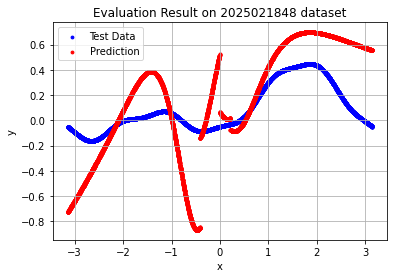

{'name': '2025021848', 'Error': 0.11421467399597168}


In [11]:
# SECTION 11 — Load the saved TorchScript model and call evaluate_model(...) on the clean practice set (data1).
# This mirrors the grading pathway and verifies the artifact loads & runs correctly.

from eval import evaluate_model
# load each train dataset, val dataset, test dataset
data_test = np.load(f"data1/clean_data.npz")
xt, yt = data_test["x"], data_test["y"]

mdn = torch.jit.load(f"model/2025021848.pth", map_location="cpu")
res = evaluate_model("2025021848", xt, yt, mdn, PLOT=True)
print(res)

## 6) Train for your final submission on Dataset 2

### Training on Dataset 2

In [12]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

max_epochs   = 30
batch_size   = 64
print_every  = 200          # iterations
plot_every   = 1000         # iterations (only if HAS_CLEAN)

iters_per_ep = (n_train + batch_size - 1) // batch_size
global_iter  = 0

mdn.train()

print("Done.")


Done.


### Save TorchScript (JIT) Model

In [13]:
# SECTION 10 — Switch model to eval mode on CPU and export a TorchScript (.pth) using save_jit_model().

# exit()

print("\n--- Saving JIT Model ---")
# Ensure the 'model/' directory exists (relative to notebook)
os.makedirs('model', exist_ok=True)

# Set model to evaluation mode and move to CPU before saving
mdn.eval()
mdn.cpu()

JIT_MODEL_PATH = "model/2025021848.pth"
save_jit_model(mdn, JIT_MODEL_PATH)


--- Saving JIT Model ---
Wrapping model for JIT tracing...


/home/khanhle/DL-mid-exam-eval/jit_wrap.py:13: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  pi, mu, sigma = self.model(x)


ValueError: not enough values to unpack (expected 3, got 1)